## Connect to your SAP HANA instance

The latest Python ML client for SAP HANA package update is ready for installation and can be found at: https://pypi.org/project/hana-ml/

In [1]:
## Loading the Python Machine Learning client library for SAP HANA and get the version
import hana_ml
print(hana_ml.__version__)

2.22.24091700


Connect using the secure user connection store (hdbuserstore) and a connection key, see  [documentation](https://help.sap.com/docs/SAP_HANA_CLIENT/f1b440ded6144a54ada97ff95dac7adf/708e5fe0e44a4764a1b6b5ea549b88f4.html).  

In [14]:
# Create the SAP HANA CLoud connection
import hana_ml.dataframe as dataframe
#cc = dataframe.ConnectionContext( address="<hana-cloud-hostname>", port=443,  user="<HANA-user>")
#cc = dataframe.ConnectionContext( userkey=<your-key-name>, sslValidateCertificate=False)

# Utilize connection credentials from external file
from hana_ml.dataframe import ConnectionContext
from hana_ml.algorithms.pal.utility import Settings
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini", "api")
#cc = ConnectionContext(url, port, user, pwd)
cc = ConnectionContext(userkey='<your key>')

# Control connection
print(cc.connection.isconnected())
print(cc.hana_version())

True
2.00.080.00.1729062409 (hana2sp08)


## 2.17 Time Series enhancements
### Online BCDP

In [7]:
#Prepare some tine series data for change point detection with Online BCDP
import pandas as pd
import numpy as np
#pd.set_option('max_colwidth', None) 
dates = pd.date_range('2018-03-01', '2018-03-10', freq='H')
tss = pd.DataFrame()
tss['TIMESTAMP'] = dates
tss['ID'] = np.arange(len(dates))
tss['Y'] = np.random.randint(0,1000,size=(len(dates),1))
tss['Y2'] = np.random.randint(0,1000,size=(len(dates),1))
tss.at[5, 'Y'] = -100000
tss.at[6, 'Y'] = -100300
df_timestamp = dataframe.create_dataframe_from_pandas(cc, tss, '#TEST', force=True).sort("TIMESTAMP")

# empty model table
df_model = pd.DataFrame({"TIMESTAMP": [], "ALPHA": [], "BETA": [], "KAPPA": [], "MU": [], "PROB": []})
df_model["TIMESTAMP"] = df_model["TIMESTAMP"].astype("int")
empty_model = dataframe.create_dataframe_from_pandas(connection_context=cc,
                                                     pandas_df=df_model,
                                                     table_name="PAL_ONLINE_BCPD_EMPTY_MODEL_TBL",
                                                     force=True)


dates2 = pd.date_range('2018-04-01', '2018-04-10', freq='H')
tss2 = pd.DataFrame()
tss2['TIMESTAMP'] = dates2
tss2['ID'] = np.arange(len(dates2))
tss2['Y'] = np.random.randint(0,1000,size=(len(dates2),1))
tss2['Y2'] = np.random.randint(0,1000,size=(len(dates2),1))
tss2.at[2, 'Y'] = -10000
tss2.at[3, 'Y'] = -1000
df_timestamp2 = dataframe.create_dataframe_from_pandas(cc, tss2, '#TEST', force=True).sort("TIMESTAMP")


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.38it/s]


In [10]:
from hana_ml.algorithms.pal.tsa.changepoint import OnlineBCPD
obcpd = OnlineBCPD(delay=20, 
                   threshold=0.5, 
                   prune=True)
init_model, cp = obcpd.fit_predict(data=df_timestamp, key='TIMESTAMP', endog='Y')
#display(init_model.collect())
display(cp.collect())

res = obcpd.get_stats()
display(res.collect())

,ID,POSITION,PROBABILITY
0,0,2018-04-01 04:00:00,0.904647


,ID,ALPHA,BETA,KAPPA,MU,PROB
0,0,0.1,1.000000e-02,1.0,0.000000,0.004000
1,1,0.6,2.299203e+05,2.0,479.500000,0.000158
2,2,1.1,2.410223e+05,3.0,540.333333,0.000055
3,3,1.6,2.645224e+05,4.0,477.750000,0.000031
4,4,2.1,3.343284e+05,5.0,394.200000,0.000038
...,...,...,...,...,...,...
209,209,104.6,8.918439e+06,210.0,517.890476,0.000241
210,210,105.1,8.977632e+06,211.0,516.255924,0.001216
211,211,105.6,9.067410e+06,212.0,518.259434,0.007416
212,212,106.1,9.127077e+06,213.0,516.633803,0.059276


In [11]:
model2, cp2 = obcpd.fit_predict(data=df_timestamp2)
display(model2.head(5).collect())
display(cp2.collect())

,ID,ALPHA,BETA,KAPPA,MU,PROB
0,0,0.1,0.010000,1.0,0.000000,0.004000
1,1,0.6,11664.010000,2.0,108.000000,0.000062
2,2,1.1,15480.343333,3.0,143.666667,0.000014
3,3,1.6,17335.385000,4.0,161.250000,0.000005
4,4,2.1,18406.610000,5.0,171.600000,0.000002


,ID,POSITION,PROBABILITY


## 2.18 Enhancement for Time SEries
### AdditiveModelForecast enhancements, make_future_dataframe

In [15]:
#Prepare some time series data for AdditiveModelForecast
data = [[0,'2008-02-03',9.698061122],
        [0,'2008-02-04',12.09745684],
        [0,'2008-02-05',10.63527836],
        [0,'2008-02-06',9.691716588],
        [0,'2008-02-07',9.315600883],
        [0,'2008-02-08',8.970813341],
        [0,'2008-02-09',8.589141691],
        [0,'2008-02-10',8.617400452],
        [0,'2008-02-11',8.616314282],
        [0,'2008-02-12',8.215547412],
        [0,'2008-02-13',8.064950892],
        [0,'2008-02-14',8.113426640],
        [0,'2008-02-15',7.799343398],
        [0,'2008-02-16',7.627544390],
        [0,'2008-02-17',7.555905094],
        [0,'2008-02-18',7.711548980],
        [0,'2008-02-19',7.788626066],
        [0,'2008-02-20',7.708410667],
        [0,'2008-02-21',7.768533301],
        [0,'2008-02-22',7.695303135],
        [0,'2008-02-23',7.378383713],
        [0,'2008-02-24',7.910590612],
        [0,'2008-02-25',7.626570206],
        [0,'2008-02-26',7.573531263],
        [0,'2008-02-27',7.567862605],
        [0,'2008-02-29',7.552237288],
        [0,'2008-03-02',7.336936914],
        [0,'2008-03-05',8.124743020],
        [0,'2008-03-06',7.887584032],
        [0,'2008-03-07',7.819636302],
        [0,'2008-03-08',7.383989458],
        [1,'2008-02-03',9.698061122],
        [1,'2008-02-04',12.09745684],
        [1,'2008-02-05',10.63527836],
        [1,'2008-02-06',9.691716588],
        [1,'2008-02-07',9.315600883],
        [1,'2008-02-08',8.970813341],
        [1,'2008-02-09',8.589141691],
        [1,'2008-02-10',8.617400452],
        [1,'2008-02-11',8.616314282],
        [1,'2008-02-12',8.215547412],
        [1,'2008-02-13',8.064950892],
        [1,'2008-02-14',8.113426640],
        [1,'2008-02-15',7.799343398],
        [1,'2008-02-16',7.627544390],
        [1,'2008-02-17',7.555905094],
        [1,'2008-02-18',7.711548980],
        [1,'2008-02-19',7.788626066],
        [1,'2008-02-20',7.708410667],
        [1,'2008-02-21',7.768533301],
        [1,'2008-02-22',7.695303135],
        [1,'2008-02-23',7.378383713],
        [1,'2008-02-24',7.910590612],
        [1,'2008-02-25',7.626570206],
        [1,'2008-02-26',7.573531263],
        [1,'2008-02-27',7.567862605],
        [1,'2008-02-29',7.552237288],
        [1,'2008-03-02',7.336936914],
        [1,'2008-03-05',8.124743020],
        [1,'2008-03-06',7.887584032],
        [1,'2008-03-07',7.819636302],
        [1,'2008-03-08',7.383989458]]
col_name = ["GROUP_ID_INT", "ts", "value"]
df_m = pd.DataFrame(data=data, columns=col_name)
df_massive = dataframe.create_dataframe_from_pandas(connection_context=cc, 
                                          pandas_df=df_m,
                                          table_name='DATA_MASSIVE_AMF_TBL_NOTEBOOK', 
                                          force=True, 
                                          replace=True)
df_massive = df_massive.cast('ts', 'DATE')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.27it/s]


In [16]:
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast
amf = AdditiveModelForecast(growth='linear',
                            seasonality_mode='additive',
                            seasonality=['{ "NAME": "yearly", "PERIOD":365.25, "FOURIER_ORDER":10 }',
                                         '{ "NAME": "weekly", "PERIOD":7, "FOURIER_ORDER":3 }',
                                         '{ "NAME": "daily", "PERIOD":1, "FOURIER_ORDER":4 }'],
                            num_changepoints=5,
                            changepoint_range=0.8,
                            regressor=None,
                            changepoints=None,
                            yearly_seasonality=None,
                            weekly_seasonality=None,
                            daily_seasonality=None,
                            seasonality_prior_scale=None,
                            holiday_prior_scale=None,
                            changepoint_prior_scale=None,
                            massive=False)


In [17]:
amf.fit(df_massive.filter("GROUP_ID_INT=0"), key='ts', endog='value')

In [18]:
df_test = amf.make_future_dataframe(periods=2)

In [19]:
df_test.head(2).collect()

,ts,PLACE_HOLDER
0,2008-03-09,0
1,2008-03-10,0


In [20]:
result = amf.predict(df_test, key='ts')

In [21]:
result.collect()

,ts,YHAT,YHAT_LOWER,YHAT_UPPER
0,2008-03-09,7.580412,7.118014,8.052173
1,2008-03-10,8.378299,7.890866,8.838514


In [22]:
amf = AdditiveModelForecast(growth='linear',
                            seasonality_mode='additive',
                            seasonality=['{ "NAME": "yearly", "PERIOD":365.25, "FOURIER_ORDER":10 }',
                                         '{ "NAME": "weekly", "PERIOD":7, "FOURIER_ORDER":3 }',
                                         '{ "NAME": "daily", "PERIOD":1, "FOURIER_ORDER":4 }'],
                            num_changepoints=5,
                            changepoint_range=0.8,
                            regressor=None,
                            changepoints=None,
                            yearly_seasonality=None,
                            weekly_seasonality=None,
                            daily_seasonality=None,
                            seasonality_prior_scale=None,
                            holiday_prior_scale=None,
                            changepoint_prior_scale=None,
                            massive=True)

In [23]:
amf.fit(df_massive, key='ts', group_key='GROUP_ID_INT', endog='value')

In [24]:
df_test = amf.make_future_dataframe(periods=2)

In [25]:
df_massive.filter('GROUP_ID_INT=1').tail(1).collect()

,GROUP_ID_INT,ts,value
0,1,2008-03-08,7.383989


In [26]:
df_test.filter('GROUP_ID_INT=1').head(1).collect()

,GROUP_ID_INT,ts,PLACE_HOLDER
0,1,2008-03-09,0


In [27]:
result = amf.predict(df_test, key='ts', group_key='GROUP_ID_INT')

In [28]:
result[0].collect()

,GROUP_ID,ts,YHAT,YHAT_LOWER,YHAT_UPPER
0,1,2008-03-09,7.580412,7.118014,8.052173
1,1,2008-03-10,8.378299,7.890866,8.838514
2,0,2008-03-09,7.580412,7.118014,8.052173
3,0,2008-03-10,8.378299,7.890866,8.838514


### Forecast / prediction interval quality

The function provides a method to evaluate the quality of interval forecasts,
which defined as:

$$score_{\alpha} = (U-L) + \frac{2}{\alpha}(L-V)1_{V<L} + \frac{2}{\alpha}(V-U)1_{V>U}$$

where *V* denotes the `true` value, **U** and **L** are upper and lower bounds of individual prediction respectively,
while the $\alpha$ represents the significance level for the prediction interval(i.e. 1-$\alpha$ is the
nominial coverage of the prediction interval), and $1_{*}$ is simply the indicator function for condition \*.

The computed quality measurements are most favorable for comparing the quality of prediction intervals
of the same testing dataset using different approaches, yet under the `same` significance(or equivalently, coverage)
level.


In [30]:
df_confidence = dataframe.create_dataframe_from_pandas(connection_context=cc, 
                                             pandas_df=pd.DataFrame(data=[(0,  5.0,  1.0, 10.0),
                                                                          (1,  6.0,  2.0, 11.0),
                                                                          (2,  7.0,  3.0, 12.0),
                                                                          (3,  8.0,  4.0, 13.0),
                                                                          (4,  9.0,  5.0, 14.0),
                                                                          (5,  5.0,  6.0, 15.0),
                                                                          (6, 11.0,  7.0, 16.0),
                                                                          (7, 12.0,  8.0, 17.0),
                                                                          (8, 13.0,  9.0, 18.0),
                                                                          (9, 14.0, 10.0, 19.0)], columns=["ID", "TRUE", "LOWER", "UPPER"]),
                                             table_name='DATA_INTERVAL_QUALITY', 
                                             force=True, 
                                             replace=True)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


In [31]:
from hana_ml.algorithms.pal.stats import interval_quality
res, stat = interval_quality(data=df_confidence,
                             significance_level=0.1,
                             score_type='classical', # 'msis'
                             percent=False,
                             check_consistency=True)


In [32]:
res.collect()

,ID,SCORE,REASON
0,0,9.0,"{""dispersion"":9.0,""lower_score"":0.0,""upper_sco..."
1,1,9.0,"{""dispersion"":9.0,""lower_score"":0.0,""upper_sco..."
2,2,9.0,"{""dispersion"":9.0,""lower_score"":0.0,""upper_sco..."
3,3,9.0,"{""dispersion"":9.0,""lower_score"":0.0,""upper_sco..."
4,4,9.0,"{""dispersion"":9.0,""lower_score"":0.0,""upper_sco..."
5,5,29.0,"{""dispersion"":9.0,""lower_score"":20.0,""upper_sc..."
6,6,9.0,"{""dispersion"":9.0,""lower_score"":0.0,""upper_sco..."
7,7,9.0,"{""dispersion"":9.0,""lower_score"":0.0,""upper_sco..."
8,8,9.0,"{""dispersion"":9.0,""lower_score"":0.0,""upper_sco..."
9,9,9.0,"{""dispersion"":9.0,""lower_score"":0.0,""upper_sco..."


- TOTAL_SCORE means the sum of each score.
- MSIS (Mean Scaled Interval Score) means the ratio of the mean interval score to the mean absolute scaled true value. For this function, the mean absolute scaled true value is imported by the parameter AVE_ABS_ERROR.
- COVERAGE means the ratio of the number of items that fall inside the number of data.
- ACD means the absolute coverage difference between the coverage and the significance level.

In [33]:
stat.collect()

,STAT_NAME,STAT_VALUE
0,TOTAL_SCORE,110
1,COVERAGE,0.9
2,ACD,0.8


### LTSF new NN-types

New network types are provided.

- 'NLinear'(new)
- 'DLinear'(new)
- 'XLinear'(new)
- 'SCINet' (old)

In [35]:
etth1_1000 = dataframe.create_dataframe_from_pandas(cc, 
                                                    pd.read_csv("./ETTh1.csv", 
                                                                usecols=["OT", "HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"])[0:1000].reset_index(), 
                                                    table_name="#etth1_1k", force=True)

key, endog, exog = etth1_1000.columns[0], etth1_1000.columns[-1], etth1_1000.columns[1:-1]

len_train, len_pred = 96, 64

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.56it/s]


In [36]:
display(key)
display(endog)
display(exog)

'index'

'OT'

['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']

In [37]:
etth1_1000.head(5).collect() #filter("{}<=800".format(quotename("index"))).

,index,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,333,8.306,0.670,5.224,-0.426,3.107,0.975,29.968000
1,334,8.105,0.804,5.437,-0.320,2.650,0.883,30.389999
2,335,10.114,2.545,7.640,1.137,2.589,0.914,31.375000
3,336,13.195,4.019,8.422,2.097,4.782,1.462,31.304001
4,337,13.329,4.287,8.280,1.954,4.447,1.310,32.640999


In [38]:
from hana_ml.dataframe import quotename
train_data = etth1_1000.filter("{}<=800".format(quotename("index")))

In [39]:
from hana_ml.algorithms.pal.tsa.ltsf import LTSF
import time

time_log = []

nlinear = LTSF(network_type = 'NLinear', batch_size = 8, num_epochs = 2, random_seed = 1)

dlinear = LTSF(network_type = 'DLinear', batch_size = 8, num_epochs = 2, random_seed = 1)

xlinear = LTSF(network_type = 'XLinear', batch_size = 8, num_epochs = 2, random_seed = 1)

scinet  = LTSF(network_type         = 'SCINet',
               num_levels           = 3, 
               kernel_size          = 3, 
               hidden_expansion     = 3, 
               batch_size           = 8, 
               num_epochs           = 2, 
               position_encoding    = True, 
               adjust_learning_rate = True,
               learning_rate        = 0.001,
               dropout_prob         = 0.05,
               random_seed          = 1)

time_log = []

start_time = time.time()
nlinear.fit(data=train_data, train_length=len_train, forecast_length=len_pred, key=key, endog=endog, exog=exog)
time_log.append("nlinear training time consumed: {}s".format(time.time() - start_time))
print(time_log[-1])

start_time = time.time()
dlinear.fit(data=train_data, train_length=len_train, forecast_length=len_pred, key=key, endog=endog, exog=exog)
time_log.append("dlinear training time consumed: {}s".format(time.time() - start_time))
print(time_log[-1])

start_time = time.time()
xlinear.fit(data=train_data, train_length=len_train, forecast_length=len_pred, key=key, endog=endog, exog=exog)
time_log.append("xlinear training time consumed: {}s".format(time.time() - start_time))
print(time_log[-1])

start_time = time.time()
scinet.fit(data=train_data, train_length=len_train, forecast_length=len_pred, key=key, endog=endog, exog=exog)
time_log.append("scinet training time consumed: {}s".format(time.time() - start_time))
print(time_log[-1])


nlinear training time consumed: 1.5257575511932373s
dlinear training time consumed: 1.6261522769927979s
xlinear training time consumed: 1.7253484725952148s
scinet training time consumed: 6.078626871109009s


In [40]:
prec_data = train_data.tail(96, ref_col="index")
prec_data.head(5).collect()

,index,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,705,13.262,2.746,9.168,0.426,4.295,1.553,44.389000
1,706,15.338,3.617,10.625,1.279,4.569,1.432,43.826000
2,707,16.343,3.550,10.661,0.782,5.300,1.584,45.233002
3,708,17.281,3.282,10.945,0.817,5.665,1.401,44.036999
4,709,17.750,2.746,11.300,0.782,6.153,1.492,43.685001


### Massive mode for accuracy_measure

In [43]:
from hana_ml.algorithms.pal.tsa.accuracy_measure import accuracy_measure

data = [[100, 1, 1130, 1270 ], [100, 2, 2410, 2340 ], 
        [100, 3, 2210, 2310 ], [100, 4, 2500, 2340 ], 
        [100, 5, 2432, 2348 ], [100, 6, 1980, 1890 ],
        [100, 7, 2045, 2100 ], [100, 8, 2340, 2231 ],
        [100, 9, 2460, 2401 ], [100, 10, 2350, 2310],
        [100, 11, 2345, 2340], [100, 12, 2650, 2560],
        [200, 1, 1130, 1270 ], [200, 2, 2410, 2340 ], 
        [200, 3, 2210, 2310 ], [200, 4, 2500, 2340 ], 
        [200, 5, 2432, 2348 ], [200, 6, 1980, 1890 ],
        [200, 7, 2045, 2100 ], [200, 8, 2340, 2231 ],
        [200, 9, 2460, 2401 ], [200, 10, 2350, 2310],
        [200, 11, 2345, 2340], [200, 12, 2650, 2560]]
col_name = ["GROUP_ID_INT", "ID", "ACTUAL", "FORECAST"]
df_m_1= pd.DataFrame(data=data, columns=col_name)
df_m_int = dataframe.create_dataframe_from_pandas(connection_context=cc, 
                                        pandas_df=df_m_1,
                                        table_name='DATA_MASSIVE_ACCURACY_MEASURE_INT', 
                                        force=True, 
                                        replace=True)
df_m_int = df_m_int.cast(['ACTUAL', 'FORECAST'], 'DOUBLE')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.96it/s]


In [44]:
res, err = accuracy_measure(data=df_m_int,
                            massive=True,
                            alpha1=0.5,
                            alpha2=0.7,
                            group_params= {'100': {'evaluation_metric':'spec'},
                                           '200': {'evaluation_metric':['mse', 'rmse', 'mpe', 'et', 'mad']}})
res.collect()

,GROUP_ID_INT,STAT_NAME,STAT_VALUE
0,100,SPEC,95.125000
1,200,ET,412.000000
2,200,MAD,83.500000
3,200,MPE,0.008390
4,200,MSE,8614.000000
5,200,RMSE,92.811637


### Auto Outlier Detection for Time Series

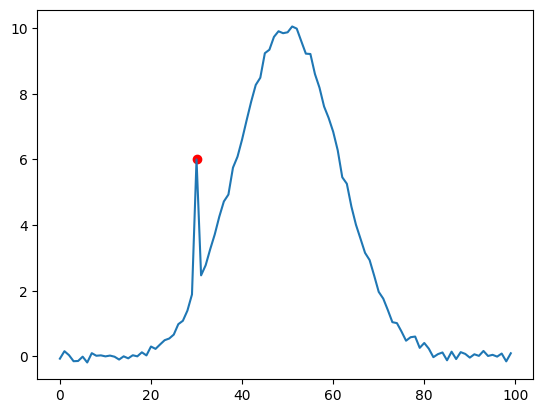

In [45]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2023)
x = np.arange(-10, 10, 0.2)
y = 10*np.exp(-0.1*x*x) + 0.4*(np.random.rand(len(x))-0.5)
y[30] = 6


plt.plot(y)
plt.scatter(30, y[30], c='red')
plt.show()

In [47]:
tdf = dataframe.create_dataframe_from_pandas(cc, pd.DataFrame(dict(ID=range(len(y)), Y=y)), '#EXP_TS_DATA_DEMO', force=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


In [48]:
from hana_ml.algorithms.pal.tsa.outlier_detection import OutlierDetectionTS
odts = OutlierDetectionTS(auto=True)
res = odts.fit_predict(tdf, key='ID', endog='Y')
res.head(40).collect() #index 30 marked as outlier

,TIMESTAMP,RAW_DATA,RESIDUAL,OUTLIER_SCORE,IS_OUTLIER
0,0,-0.070751,-0.028166,-0.162079,0
1,1,0.156844,0.202157,0.401199,0
2,2,0.036215,0.079933,0.102289,0
3,3,-0.147908,-0.127517,-0.405051,0
4,4,-0.141354,-0.126426,-0.402383,0
5,5,-0.009806,0.006103,-0.078271,0
6,6,-0.186831,-0.167482,-0.502791,0
7,7,0.097047,0.119405,0.198821,0
8,8,0.018377,0.044097,0.014648,0
9,9,0.029991,0.051996,0.033965,0


## 2.19 Time Series enhancements
### STL decomposition method 
`~hana_ml.algorithms.pal.tsa.seasonal_decompose.seasonal_decompose` by offering new parameters 'decompose_method', 'stl_robust' and 'stl_seasonal_average'.

In [49]:
#Load sample datasets for the AutoML example
from hana_ml.algorithms.pal.utility import DataSets
shampoo_data = DataSets.load_shampoo_data(cc)

Table SHAMPOO_SALES_DATA_TBL exists.


In [50]:
shampoo_data.head(3).collect()

,ID,SALES
0,1,266.0
1,2,145.9
2,3,183.1


In [51]:
from hana_ml.algorithms.pal.tsa.seasonal_decompose import seasonal_decompose

stats, decompose = seasonal_decompose(data=shampoo_data, endog='SALES', decompose_method='stl', stl_robust=True, stl_seasonal_average=True)
decompose.head(3).collect()

,ID,SEASONAL,TREND,RANDOM
0,1,1.049177,153.210869,1.654791
1,2,0.949511,155.169938,0.990256
2,3,1.049177,157.154062,1.110488


### LTSF decomposition 
Provide explainability support in :class:`~hana_ml.algorithms.pal.tsa.ltsf.LTSF`.

In [52]:
from hana_ml.algorithms.pal.tsa.ltsf import LTSF
ltsf = LTSF(num_levels           = 3, 
            kernel_size          = 3, 
            hidden_expansion     = 3, 
            batch_size           = 4, 
            num_epochs           = 4, 
            position_encoding    = True, 
            adjust_learning_rate = True,
            learning_rate        = 0.005,
            dropout_prob         = 0.15,
            random_seed          = 1,
            network_type         = 'XLinear')

ltsf.fit(data=shampoo_data, train_length=30, forecast_length=6, key="ID", endog="SALES")

In [53]:
ltsf.predict(data=shampoo_data, show_explainer=True)[1].collect()

,ID,NAME,VALUE,PERCENTAGE
0,0,TREND,343.117567,None
1,0,SEASONAL,34.441741,None
2,1,TREND,206.924452,None
3,1,SEASONAL,14.564783,None
4,2,TREND,340.515845,None
5,2,SEASONAL,63.246763,None
6,3,TREND,307.414471,None
7,3,SEASONAL,23.435531,None
8,4,TREND,329.598019,None
9,4,SEASONAL,35.368098,None


In [54]:
import numpy as np
import pandas as pd
etth1_1000 = dataframe.create_dataframe_from_pandas(cc, pd.read_csv("./ETTh1.csv", 
                                                                    usecols=["OT", "HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"])[0:1000].reset_index(), 
                                                    table_name="ETTH", force=True)

key, endog, exog = etth1_1000.columns[0], etth1_1000.columns[-1], etth1_1000.columns[1:-1]

len_train, len_pred = 96, 64
print(key, endog , exog)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.25it/s]


index OT ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']


In [55]:
etth1_1000 = etth1_1000.to_head('OT').to_head('index')

In [56]:
etth1_1000.head(2).collect()

,index,OT,HUFL,HULL,MUFL,MULL,LUFL,LULL
0,0,30.531000,5.827,2.009,1.599,0.462,4.203,1.340
1,1,27.787001,5.693,2.076,1.492,0.426,4.142,1.371


In [57]:
# What does the target value distribution look like
ratio = etth1_1000.agg([('count', 'index', 'N')]).collect()
display(ratio)

,N
0,1000


In [58]:
cc.sql('select count(distinct "index"), min("index"), max("index") from "ETTH"').collect()

,COUNT(DISTINCT index),MIN(index),MAX(index)
0,1000,0,999


In [59]:
from hana_ml.algorithms.pal.tsa.ltsf import LTSF
ltsf = LTSF(num_levels           = 3, 
            kernel_size          = 3, 
            hidden_expansion     = 3, 
            batch_size           = 4, 
            num_epochs           = 4, 
            position_encoding    = True, 
            adjust_learning_rate = True,
            learning_rate        = 0.005,
            dropout_prob         = 0.15,
            random_seed          = 1,
            network_type         = 'XLinear')

ltsf.fit(data=etth1_1000, train_length=800, forecast_length=200, endog="OT" , key="index", exog=["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]) 

In [60]:
etth1_1000.head(2).collect() #deselect("OT")

,index,OT,HUFL,HULL,MUFL,MULL,LUFL,LULL
0,0,30.531000,5.827,2.009,1.599,0.462,4.203,1.340
1,1,27.787001,5.693,2.076,1.492,0.426,4.142,1.371


In [61]:
forecast_tbl, decompose_tbl = ltsf.predict(data=etth1_1000, key="index", endog="OT", show_explainer=True, allow_new_index=False) #.deselect("OT") 
display(forecast_tbl.head(2).collect())
display(decompose_tbl.head(30).collect())

,ID,FORECAST
0,0,25.174206
1,1,19.186185


,ID,NAME,VALUE,PERCENTAGE
0,0,TREND,27.098502,NaN
1,0,SEASONAL,-2.760334,NaN
2,0,HUFL,-1.969921,20.563421
3,0,HULL,0.941052,9.823365
4,0,MUFL,-1.625225,16.965240
5,0,MULL,-2.348763,24.518040
6,0,LUFL,-1.655903,17.285478
7,0,LULL,1.038870,10.844457
8,1,TREND,26.155507,NaN
9,1,SEASONAL,-2.324562,NaN


## 2.20 Time Series Analysis and Forecasting enhancements

### Time series outlier detection with voting

In [64]:
# create the ts data for illustrating this feature
data = [[1,  '2008-03-09',  13],
        [2,  '2008-03-10',  16],
        [3,  '2008-03-11',  14],
        [4,  '2008-03-12',  10],
        [5,  '2008-03-13',  10],
        [6,  '2008-03-14',  510],
        [7,  '2008-03-15',  510],
        [8,  '2008-03-16',  510],
        [9,  '2008-03-17',  510],
        [10, '2008-03-18',  516]]
col_name = ["ID", "timestamp", "y"]
df_s = pd.DataFrame(data=data, columns=col_name)
df_s = dataframe.create_dataframe_from_pandas(connection_context=cc, 
                                    pandas_df=df_s,
                                    table_name='TEST_SINGLE_OUTLIER_DETECTION', 
                                    force=True, 
                                    replace=True)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


In [65]:
# Using voting_config for defining which stats to be used with the outlier voting
from hana_ml.algorithms.pal.tsa.outlier_detection import OutlierDetectionTS

od = OutlierDetectionTS(window_size=5,
                        detect_seasonality=False,                 
                        outlier_method='z1',
                        threshold=5,
                        contamination=0.5,
                        voting_outlier_method_criterion=0.5,
                        dbscan_normalization=False,
                        voting_config={"z1": {"threshold":100}, "z2": {"threshold":1}, 
                                       "iqr": {"threshold":2}, "mad":{"threshold":3},  
                                       "isolationforest": {"contamination":0.4},
                                       "dbscan": {'minpts':1,
                                                  "eps":0.5,
                                                  "distiance_method":"euclidean", 
                                                  "dbscan_normalization":True,
                                                  "dbscan_outlier_from_cluster":False}},
                       residual_usage="outlier_correction")
res=od.fit_predict(data=df_s, key='ID', endog='y')

print(od.stats_.collect(), '\n')
print(res.head(2).collect())

                                      STAT_NAME                     STAT_VALUE
0                           Auto Outlier Method                  median filter
1                        DETECT_INTERMITTENT_TS                              0
2                             INTERMITTENT_FLAG                              0
3             REMOVE_LEADING_AND_TRAILING_ZEROS                              0
4                                    OutlierNum                              4
5                                    HandleZero                              1
6                             ID of Z1 Outliers                               
7                ID of Z1 Supplemented Outliers                               
8                             ID of Z2 Outliers                        2, 5, 6
9                ID of Z2 Supplemented Outliers                           5, 6
10                           ID of IQR Outliers                  2, 4, 5, 6, 7
11              ID of IQR Supplemented Outliers     

### Segmented (massive-parallel) time series Online Bayesian Change Point Detection (Online BCPD)

In [67]:
# create the ts data for illustrating this feature
data = [['100', 100, 1,  '2008-03-09',  13],
        ['100', 100, 2,  '2008-03-10',  16],
        ['100', 100, 3,  '2008-03-11',  14],
        ['100', 100, 4,  '2008-03-12',  10],
        ['100', 100, 5,  '2008-03-13',  10],
        ['100', 100, 6,  '2008-03-14',  510],
        ['100', 100, 7,  '2008-03-15',  510],
        ['100', 100, 8,  '2008-03-16',  510],
        ['100', 100, 9,  '2008-03-17',  510],
        ['100', 100, 10, '2008-03-18',  516],        
        ['200', 200, 1,  '2008-07-09',  0],
        ['200', 200, 2,  '2008-07-10',  0],
        ['200', 200, 3,  '2008-07-11',  0],
        ['200', 200, 4,  '2008-07-12',  13],
        ['200', 200, 5,  '2008-07-13',  10],
        ['200', 200, 6,  '2008-07-14',  10],
        ['200', 200, 7,  '2008-07-15',  12],
        ['200', 200, 8,  '2008-07-16',  10],
        ['200', 200, 9,  '2008-07-17',  18],
        ['200', 200, 10, '2008-07-18',  0]]
col_name = ["GROUP_id_NAR", "GROUP_id_INT", "ID", "timestamp", "y"]
df_m = pd.DataFrame(data=data, columns=col_name)
df_m = dataframe.create_dataframe_from_pandas(connection_context=cc, 
                                    pandas_df=df_m,
                                    table_name='DATA_MASSIVE_ONLINE_BCPD_NOTEBOOK', 
                                    force=True, 
                                    replace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.18it/s]


In [72]:
# Using the massive-parameter for invoking segmented time series online BCPD
from hana_ml.algorithms.pal.tsa.changepoint import OnlineBCPD

obcpd = OnlineBCPD(massive=True,
                   group_params= {'100': {'threshold':10, 'prune' :False, 'delay':10},
                                  '200': {'threshold':200, 'prune' :True,  'delay':200}})
init_model, cp = obcpd.fit_predict(data=df_m, group_key="GROUP_id_NAR", key='timestamp', endog='y')
display(cp.collect())
display(init_model.head(30).collect())

,GROUP_ID,ID,POSITION,PROBABILITY


,GROUP_ID,ID,ALPHA,BETA,KAPPA,MU,PROB
0,200,0,0.1,0.010000,1.0,0.000000,4.000000e-03
1,200,1,0.6,0.010000,2.0,0.000000,1.103714e-01
2,200,2,1.1,108.010000,3.0,6.000000,4.821263e-04
3,200,3,1.6,114.010000,4.0,7.000000,2.083579e-04
4,200,4,2.1,124.010000,5.0,8.000000,1.436522e-04
5,200,5,2.6,125.676667,6.0,8.333333,1.394858e-04
6,200,6,3.1,126.867143,7.0,8.571429,2.369358e-04
7,200,7,3.6,135.447500,8.0,9.125000,8.770164e-01
8,200,8,4.1,172.454444,9.0,8.111111,5.945171e-03
9,200,9,4.6,202.060000,10.0,7.300000,7.796691e-05


### Time Series external feature importance evaluation using value permutation 

In [76]:
# create the ts data for illustrating this feature
import pandas as pd
from hana_ml.dataframe import create_dataframe_from_pandas
data_s = [[ 0 , '2018-03-01 00:00:00', 1001.186965,  1001.381398, 0],
          [ 1 , '2018-03-01 01:00:00',  999.743681,  1000.449621, 0],
          [ 2 , '2018-03-01 02:00:00',  998.273447,  1000.202493, 0],
          [ 3 , '2018-03-01 03:00:00',  998.163017,   999.517705, 0],
          [ 4 , '2018-03-01 04:00:00', 1001.023297,  1000.149800, 0],
          [ 5 , '2018-03-01 05:00:00', 1001.802838,   999.582847, 1],
          [ 6 , '2018-03-01 06:00:00', 1000.902042,  1001.485573, 0],
          [ 7 , '2018-03-01 07:00:00',  999.679829,  1000.480978, 0],
          [ 8 , '2018-03-01 08:00:00', 1000.374643,   998.741293, 1],
          [ 9 , '2018-03-01 09:00:00',  998.764213,   997.642889, 0],
          [ 10, '2018-03-01 10:00:00',  997.452251,   997.075054, 0],
          [ 11, '2018-03-01 11:00:00',  996.122439,   998.310629, 0],
          [ 12, '2018-03-01 12:00:00',  994.911779,   998.415049, 0],
          [ 13, '2018-03-01 13:00:00',  994.764867,   998.523278, 0],
          [ 14, '2018-03-01 14:00:00',  995.957687,   998.204968, 0],
          [ 15, '2018-03-01 15:00:00',  994.190517,   996.617601, 0],
          [ 16, '2018-03-01 16:00:00',  994.111706,   996.972823, 0],
          [ 17, '2018-03-01 17:00:00',  994.128363,   997.372093, 0],
          [ 18, '2018-03-01 18:00:00',  993.700500,   995.882251, 1],
          [ 19, '2018-03-01 19:00:00',  993.504805,   995.968155, 0],
          [ 20, '2018-03-01 20:00:00',  993.394271,   996.612626, 2],
          [ 21, '2018-03-01 21:00:00',  994.302608,   997.103210, 0],
          [ 22, '2018-03-01 22:00:00',  993.106145,   997.017516, 0],
          [ 23, '2018-03-01 23:00:00',  993.412343,   997.597426, 0],
          [ 24, '2018-03-02 00:00:00',  993.304751,   996.252572, 0]]
col_name = ["ID_INT", "ID_TIMESTAMP", "endog", "exog", "cate"]
df_s = pd.DataFrame(data=data_s, columns=col_name)
df_s = create_dataframe_from_pandas(connection_context=cc, 
                                          pandas_df=df_s,
                                          table_name='DATA_ARIMA_TBL_NOTEBOOK', 
                                          force=True, 
                                          replace=True)
data_p_s = [[ 1,  '2018-03-02 01:00:00',  998.37443, 998.364324, 0],
            [ 2,  '2018-03-02 02:00:00',  1002.74643, 997.995616, 0],
            [ 3,  '2018-03-02 03:00:00',  1001.31243, 996.582251, 1],
            [ 4,  '2018-03-02 04:00:00',  1003.97401, 994.965102, 1],
            [ 5,  '2018-03-02 05:00:00',  1000.37643, 995.522703, 0]]
col_name = ["ID_INT", "ID_TIMESTAMP", "endog", "exog", "cate"]
data_p_s = pd.DataFrame(data=data_p_s, columns=col_name)

data_p_s = create_dataframe_from_pandas(connection_context=cc, 
                                            pandas_df=data_p_s,
                                            table_name='DATA_ARIMA_PREDICT_TBL_NOTEBOOK', 
                                            force=True, 
                                            replace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.62it/s]


In [77]:
from hana_ml.algorithms.pal.tsa.arima import ARIMA
from hana_ml.algorithms.pal.tsa.permutation_importance import permutation_importance
# ARIMA ID=INT
ar = ARIMA()
ar.fit(df_s, key='ID_INT', endog='endog', exog=['exog', 'cate'])
print(ar.model_.head(2).collect())
#res = ar.predict(df_s_p.deselect(['ID_TIMESTAMP', 'endog']), key='ID_INT')
#print(res.collect())
pires = permutation_importance(data=data_p_s, model=ar.model_, key='ID_INT', endog='endog', exog=['exog', 'cate'])
print(pires.collect())

  KEY VALUE
0   p     0
1  AR      
  PAIR  NAME       VALUE
0  MSE  cate  311.139216
1  MSE  exog  287.786977
